## **XGBoost Regressor**

In [1]:
import os
import numpy as np
import copy
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0630.git

Cloning into 'DX-Training-LGES-0630'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 57 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [3]:
# import dataset

data = pd.read_csv('/content/DX-Training-LGES-0630/Data/Data_XGBoost_AirQuality.csv')

del data['Unnamed: 0']
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# select a feature (CO(GT))

name = "CO(GT)"
SIZE = 24

data = data[name]

In [5]:
# for using t0 ~ t23 (24 times)

COLUMNS = ['t{}'.format(x) for x in range(SIZE)] + ['target']
COLUMNS

['t0',
 't1',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 't10',
 't11',
 't12',
 't13',
 't14',
 't15',
 't16',
 't17',
 't18',
 't19',
 't20',
 't21',
 't22',
 't23',
 'target']

In [6]:
time_data = []

for i in range(SIZE, data.shape[0]):
    time_data.append(data.loc[i-SIZE:i].tolist())
time_data = pd.DataFrame(time_data, columns = COLUMNS)
time_data.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t15,t16,t17,t18,t19,t20,t21,t22,t23,target
0,2.6,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,...,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8
1,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,...,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9
2,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,...,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1
3,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,...,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9
4,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,...,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9,1.5


## Time series components
### base-level, trend, seasonality

In [7]:
feats_data = pd.DataFrame()
feats_data['prev_1'] = time_data.iloc[:,-2] # Here -2 as -1 is a target

for win in range(3, 27, 3):
    # select columns by recent times
    tmp = time_data.iloc[:,-1-win:-1]
    print(tmp)

    #General statistics for base level
    feats_data['mean_prev_{}'.format(win)] = tmp.mean(axis=1) # mean
    feats_data['median_prev_{}'.format(win)] = tmp.median(axis=1) # median
    feats_data['min_prev_{}'.format(win)] = tmp.min(axis=1) # min
    feats_data['max_prev_{}'.format(win)] = tmp.max(axis=1) # max
    feats_data['std_prev_{}'.format(win)] = tmp.std(axis=1) # standard deviation
    
    #Capturing trend
    feats_data['mean_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1) # ewm; Exponential Moving Average
    feats_data['last_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]
    
    feats_data['avg_diff_{}'.format(win)] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
    feats_data['avg_div_{}'.format(win)] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)

      t21  t22  t23
0     2.2  2.2  2.9
1     2.2  2.9  4.8
2     2.9  4.8  6.9
3     4.8  6.9  6.1
4     6.9  6.1  3.9
...   ...  ...  ...
9328  4.0  5.0  3.9
9329  5.0  3.9  3.1
9330  3.9  3.1  2.4
9331  3.1  2.4  2.4
9332  2.4  2.4  2.1

[9333 rows x 3 columns]
      t18  t19  t20  t21  t22  t23
0     1.6  1.9  2.9  2.2  2.2  2.9
1     1.9  2.9  2.2  2.2  2.9  4.8
2     2.9  2.2  2.2  2.9  4.8  6.9
3     2.2  2.2  2.9  4.8  6.9  6.1
4     2.2  2.9  4.8  6.9  6.1  3.9
...   ...  ...  ...  ...  ...  ...
9328  0.5  0.5  1.1  4.0  5.0  3.9
9329  0.5  1.1  4.0  5.0  3.9  3.1
9330  1.1  4.0  5.0  3.9  3.1  2.4
9331  4.0  5.0  3.9  3.1  2.4  2.4
9332  5.0  3.9  3.1  2.4  2.4  2.1

[9333 rows x 6 columns]
      t15  t16  t17  t18  t19  t20  t21  t22  t23
0     2.2  1.7  1.5  1.6  1.9  2.9  2.2  2.2  2.9
1     1.7  1.5  1.6  1.9  2.9  2.2  2.2  2.9  4.8
2     1.5  1.6  1.9  2.9  2.2  2.2  2.9  4.8  6.9
3     1.6  1.9  2.9  2.2  2.2  2.9  4.8  6.9  6.1
4     1.9  2.9  2.2  2.2  2.9  4.8  6.9 

In [8]:
feats_data

,prev_1,mean_prev_3,median_prev_3,min_prev_3,max_prev_3,std_prev_3,mean_ewm_prev_3,last_ewm_prev_3,avg_diff_3,avg_div_3,...,avg_div_21,mean_prev_24,median_prev_24,min_prev_24,max_prev_24,std_prev_24,mean_ewm_prev_24,last_ewm_prev_24,avg_diff_24,avg_div_24
0,2.9,2.433333,2.2,2.2,2.9,0.404145,2.285679,2.457036,0.35,1.159091,...,1.052296,1.658333,1.65,0.6,2.9,0.703356,1.651688,1.868300,0.013043,1.039789
1,4.8,3.300000,2.9,2.2,4.8,1.345362,2.718254,3.387261,1.30,1.486677,...,1.098691,1.750000,1.65,0.6,4.8,0.936227,1.568964,2.168368,0.121739,1.078308
2,6.9,4.866667,4.8,2.9,6.9,2.000833,3.932500,5.000000,2.00,1.546336,...,1.133066,1.954167,1.65,0.6,6.9,1.408354,1.580077,2.665456,0.204348,1.092982
3,6.1,5.933333,6.1,4.8,6.9,1.059874,5.559174,5.975021,0.65,1.160779,...,1.127269,2.116667,1.65,0.6,6.9,1.643344,1.569810,3.029531,0.169565,1.087941
4,3.9,5.633333,6.1,3.9,6.9,1.553491,6.304213,5.532639,-1.50,0.761701,...,1.117569,2.187500,1.65,0.6,6.9,1.683245,1.538297,3.128550,0.100000,1.084118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,3.9,4.300000,4.0,3.9,5.0,0.608276,4.273501,4.295504,-0.05,1.015000,...,1.198742,1.583333,1.25,0.4,5.0,1.198429,1.358440,1.961565,0.108696,1.160636
9329,3.1,4.000000,3.9,3.1,5.0,0.953939,4.453129,3.936886,-0.95,0.787436,...,1.188486,1.654167,1.25,0.4,5.0,1.236749,1.378548,2.086105,0.078261,1.154823
9330,2.4,3.133333,3.1,2.4,3.9,0.750555,3.487810,3.083430,-0.75,0.784533,...,1.172195,1.700000,1.25,0.4,5.0,1.243417,1.412751,2.126428,0.043478,1.141660
9331,2.4,2.633333,2.4,2.4,3.1,0.404145,2.814303,2.610408,-0.35,0.887097,...,1.163104,1.741667,1.25,0.4,5.0,1.249667,1.426461,2.161964,0.060870,1.154083


In [9]:
# 7 for week

for win in [2, 3, 4]:

    tmp = time_data.iloc[:,-1-win*6:-1:6] # row, col, step
    print(tmp)

    #Features for weekly seasonality
    feats_data['6days_mean_prev_{}'.format(win)] = tmp.mean(axis=1)
    feats_data['6days_median_prev_{}'.format(win)] = tmp.median(axis=1)
    feats_data['6days_min_prev_{}'.format(win)] = tmp.min(axis=1)
    feats_data['6days_max_prev_{}'.format(win)] = tmp.max(axis=1)
    feats_data['6days_std_prev_{}'.format(win)] = tmp.std(axis=1)

feats_data = pd.concat([feats_data, time_data.iloc[:, -1]], axis = 1)

      t12  t18
0     0.7  1.6
1     1.1  1.9
2     2.0  2.9
3     2.2  2.2
4     1.7  2.2
...   ...  ...
9328  1.6  0.5
9329  1.2  0.5
9330  0.9  1.1
9331  0.6  4.0
9332  0.5  5.0

[9333 rows x 2 columns]
       t6  t12  t18
0     1.2  0.7  1.6
1     1.0  1.1  1.9
2     0.9  2.0  2.9
3     0.6  2.2  2.2
4     0.7  1.7  2.2
...   ...  ...  ...
9328  1.3  1.6  0.5
9329  1.4  1.2  0.5
9330  1.2  0.9  1.1
9331  2.7  0.6  4.0
9332  2.5  0.5  5.0

[9333 rows x 3 columns]
       t0   t6  t12  t18
0     2.6  1.2  0.7  1.6
1     2.0  1.0  1.1  1.9
2     2.2  0.9  2.0  2.9
3     2.2  0.6  2.2  2.2
4     1.6  0.7  1.7  2.2
...   ...  ...  ...  ...
9328  1.4  1.3  1.6  0.5
9329  1.3  1.4  1.2  0.5
9330  1.4  1.2  0.9  1.1
9331  1.0  2.7  0.6  4.0
9332  1.0  2.5  0.5  5.0

[9333 rows x 4 columns]


In [10]:
feats_data

,prev_1,mean_prev_3,median_prev_3,min_prev_3,max_prev_3,std_prev_3,mean_ewm_prev_3,last_ewm_prev_3,avg_diff_3,avg_div_3,...,6days_median_prev_3,6days_min_prev_3,6days_max_prev_3,6days_std_prev_3,6days_mean_prev_4,6days_median_prev_4,6days_min_prev_4,6days_max_prev_4,6days_std_prev_4,target
0,2.9,2.433333,2.2,2.2,2.9,0.404145,2.285679,2.457036,0.35,1.159091,...,1.2,0.7,1.6,0.450925,1.525,1.40,0.7,2.6,0.805709,4.8
1,4.8,3.300000,2.9,2.2,4.8,1.345362,2.718254,3.387261,1.30,1.486677,...,1.1,1.0,1.9,0.493288,1.500,1.50,1.0,2.0,0.522813,6.9
2,6.9,4.866667,4.8,2.9,6.9,2.000833,3.932500,5.000000,2.00,1.546336,...,2.0,0.9,2.9,1.001665,2.000,2.10,0.9,2.9,0.828654,6.1
3,6.1,5.933333,6.1,4.8,6.9,1.059874,5.559174,5.975021,0.65,1.160779,...,2.2,0.6,2.2,0.923760,1.800,2.20,0.6,2.2,0.800000,3.9
4,3.9,5.633333,6.1,3.9,6.9,1.553491,6.304213,5.532639,-1.50,0.761701,...,1.7,0.7,2.2,0.763763,1.550,1.65,0.7,2.2,0.624500,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,3.9,4.300000,4.0,3.9,5.0,0.608276,4.273501,4.295504,-0.05,1.015000,...,1.3,0.5,1.6,0.568624,1.200,1.35,0.5,1.6,0.483046,3.1
9329,3.1,4.000000,3.9,3.1,5.0,0.953939,4.453129,3.936886,-0.95,0.787436,...,1.2,0.5,1.4,0.472582,1.100,1.25,0.5,1.4,0.408248,2.4
9330,2.4,3.133333,3.1,2.4,3.9,0.750555,3.487810,3.083430,-0.75,0.784533,...,1.1,0.9,1.2,0.152753,1.150,1.15,0.9,1.4,0.208167,2.4
9331,2.4,2.633333,2.4,2.4,3.1,0.404145,2.814303,2.610408,-0.35,0.887097,...,2.7,0.6,4.0,1.715615,2.075,1.85,0.6,4.0,1.573478,2.1


## Modeling part

In [11]:
from sklearn.metrics import mean_squared_error as mse

# split train and test data
train_data      = feats_data.iloc[0:8000, :]
validation_data = feats_data.iloc[8000:9000, :]
test_data       = feats_data.iloc[9000:, :]

X_train = copy.copy(train_data.iloc[:, :-1]); Y_train = copy.copy(train_data.iloc[:, -1])
X_test  = copy.copy(test_data.iloc[:, :-1]);  Y_test  = copy.copy(test_data.iloc[:, -1])

## XGBoost
#### 파라미터 참조 : https://xgboost.readthedocs.io/en/stable/parameter.html

[08:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE : 0.3092140587107818


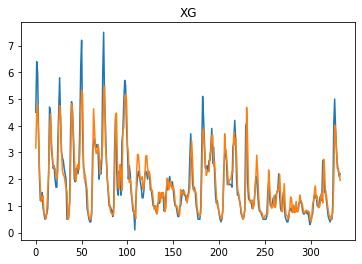

In [12]:
from xgboost import XGBRegressor

model_XG = XGBRegressor() # model define
model_XG.fit(X_train, Y_train) # model train

pred = model_XG.predict(X_test) # predict

# visualize the results
plt.title("XG")
plt.plot(Y_test.values)
plt.plot(pred)

print("MSE : " + str(mse(Y_test.values, pred)))